In [70]:
cd ..

/home/pablo/Programming/papers


In [71]:
from matplotlib.pyplot import *
%matplotlib inline

In [72]:
# %load make_initial_guess.py
from dolo import *
import numpy

def dr_init(model, i, s):

    from numpy import arctan, exp
    from numpy import pi

    beta, delta, theta, psi, gamma, a1, a2, xi, min_b, max_b, fac, bm, theta_f, kmin = model.get_calibration([
            'beta', 'delta', 'theta', 'psi', 'gamma', 'a1', 'a2', 'xi', 'min_b', 'max_b', 'fac', 'bm', 'theta_f', 'kmin'])

    k_1 = s[:,0]
    #sparsity = s[:,1]
    #k_2 = k_1*sparsity
    k_2 = s[:,1]
#    b_f = arctan( s[:,2] )/pi*2*0.8
    bl = s[:,2]

    A_1, A_2, E = model.markov_chain[0][i,:]

#     min_c = -k_1**theta_f*fac #*0 + min_b
#     max_c = k_2**theta_f*fac #*0 + max_b
    min_c = -(max_b + exp(-theta_f*(k_1-kmin))*(bm-max_b))
    max_c = max_b + exp(-theta_f*(k_2-kmin))*(bm-max_b)

#     print("min_c")
#     print(min_c)
#     print("max_c")
#     print(max_c)
#     min_c = -fac
#     max_c = fac
    b_f = (bl+1)/2*max_c + (1-bl)/2*min_c
    
    i_1 = k_1*delta
    i_2 = k_2*delta
    b   = b_f
    p = b_f*0 + beta

    N = s.shape[0]
    val = numpy.zeros( (N,8))

    val[:,0] = b #[None,:]
    val[:,1] = p #[None,:]
    val[:,2] = i_1 #[None,:]
    val[:,3] = i_2 #[None,:]

    c_1 = exp(A_1)*k_1**theta - i_1 + b*(1-p)
    c_2 = exp(A_2)*k_2**theta - i_2 - b*(1-p)
    val[:,4] = c_1
    val[:,5] = c_2
    val[:,6] = c_1
    val[:,7] = c_2

    return val


In [73]:
from dolo import *
# model = yaml_import("models/integration_B.yaml")
model = yaml_import("models/integration_t_B.yaml")
# model = yaml_import("models/autarky.yaml")
from dolo.algos.dtmscc.time_iteration import time_iteration as timio
from time_iteration import time_iteration


dri = lambda i,s: dr_init(model, i, s)

import time

IOError: [Errno 2] No such file or directory: 'models/integration_t_B.yaml'

In [74]:
model.set_calibration(N_k=30, N_b=30, n_a=2, psi=4.0, xi=0.2,
                      gamma=4.0, min_b=-15, max_b=15,
                      kmin=1, kmax=9, bm=4.0, fac=5, theta_f=0.5) #-0.001)

In [75]:
s = model.calibration['states'].copy()
s[0] = 1.01
s[1] = 1.01
s[2] = 1.01 # -0.99999
i0 = 3

x = dri(i0,s[None,:])[0,:]
p = model.calibration['parameters']
m = model.calibration['markov_states']
y = model.functions['auxiliary'](m, s,x,p)

In [76]:
model.get_calibration('max_b')

15.0

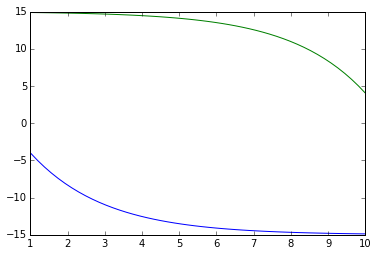

In [67]:
s = model.calibration['states']
p = model.calibration['parameters']
x_lb = model.functions['controls_lb']
x_ub = model.functions['controls_ub']
kvec = numpy.linspace(1.01, 10)
lims_lb = [x_lb(numpy.array([0.0, 0.0, 0.0]),
                numpy.array([k,1.01,0.0]),p) for k in  kvec]
lims_ub = [x_ub(numpy.array([0.0, 0.0, 0.0]),
                     numpy.array([1.01,k,0.0]),p) for k in  kvec]
lims_ub.reverse()
plot(kvec, [l[0] for l in lims_lb])
plot(kvec, [l[0] for l in lims_ub])

In [68]:
l = []
def hook():
    import inspect
    d = inspect.currentframe().f_back.f_locals
    l.append([d['full_grid'], d['controls_0'], d['mdr'].copy()])

In [69]:
t1 = time.time()
dr = time_iteration(model, initial_guess=dri, verbose='full', inner_maxit=10, maxit=20, hook=hook)
t2 = time.time()
# timio(model, initial_guess=dri, verbose='full')
#t3 = time.time()
print("New {}".format(t2-t1))
#print("Old {}".format(t3-t2))

Solving WITH complementarities.
------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------
	> 1 | 1.7110415005 | 3 | [1.0, 0.178, 0.015175925925925926, 6.481481481481482e-05]
	> 2 | 0.687577947275 | 5 | [1.0, 0.03224074074074074, 0.007046296296296296, 0.000537037037037037, 9.259259259259259e-05, 3.7037037037037037e-05]
	> 3 | 0.189036392859 | 5 | [1.0, 0.013351851851851853, 0.005981481481481482, 0.0021759259259259258, 0.0005092592592592592, 4.6296296296296294e-05]
	> 4 | 0.0675279319368 | 4 | [1.0, 0.010944444444444444, 0.005157407407407407, 0.0014722222222222222, 0.0003981481481481481]
	> 5 | 0.040914453437 | 4 | [0.9893333333333333, 0.007759259259259259, 0.003638888888888889, 0.000462962962962963, 1.8518518518518518e-05]
	> 6 | 0.032771295302 | 10 | [0.5713796296296296, 0.004314814814814815, 0.001712962962962963, 0.0004351851851851852, 2.777777777777778e-05, 1.8518518518518518e-05, 1.8518518518518

Exception: Error solving point 0

In [ ]:
dr = time_iteration(model, initial_guess=dr, verbose='full', inner_maxit=3)


In [58]:
sim = simulate(model, dr, 0, n_exp=1000, horizon=500)

(500, 1000, 24)


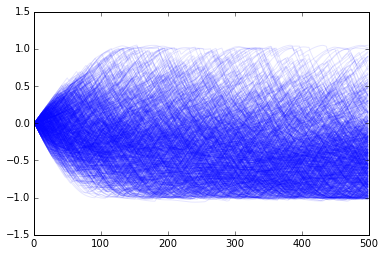

In [60]:
for i in range(sim.shape[0]):
    plot(sim[i]['bl'], color='blue', alpha=0.1)

In [72]:
i = 
horizon = 500
markov_indices = numpy.zeros(horizon) + i
sim = simulate(model, dr, 0, n_exp=0, horizon=horizon, markov_indices=markov_indices)

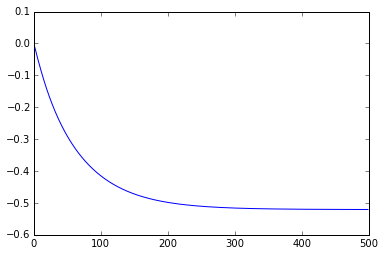

In [73]:
plot(sim['bl'], color='blue')

In [10]:
from matplotlib.pyplot import *
%matplotlib inline

In [45]:
dr = l[-1][-1]

In [50]:
sim = plot_decision_rule(model, dr, 'bl')

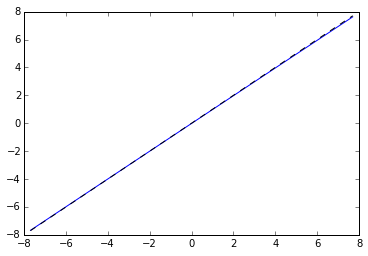

In [51]:
plot(sim['b_f'], sim['db_f'])
plot(sim['b_f'], sim['b_f'], color='black', linestyle='--')

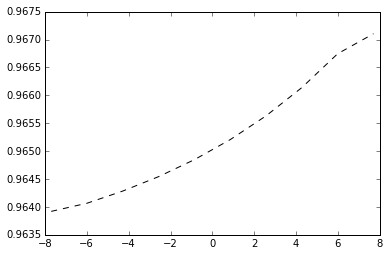

In [52]:
plot(sim['b_f'], sim['p_f'], color='black', linestyle='--')

In [10]:
from dolo.algos.dtmscc.simulations import simulate

In [11]:
horizon = 1000
markov_indices = numpy.zeros((horizon))+1

In [77]:
tsim = simulate(model, dr, markov_indices[0], n_exp=0, horizon=horizon, markov_indices=markov_indices)

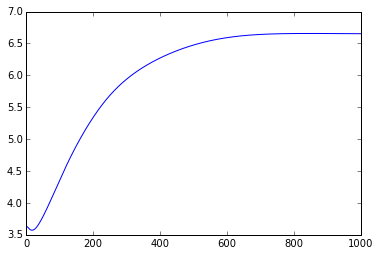

In [78]:
plot(tsim['k_1'])

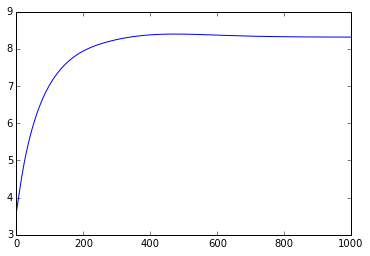

In [79]:
plot(tsim['k_2'])

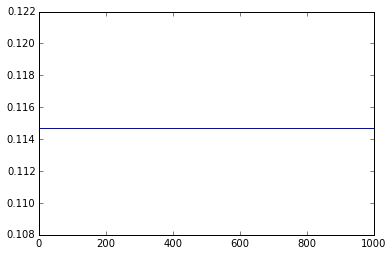

In [80]:
plot(tsim['A_2'])

In [88]:
tsim['k_1'].iloc[-1]

6.6534437327952398

In [14]:
s0 = numpy.array([tsim['k_1'].iloc[-1], tsim['k_2'].iloc[-1], 0])

NameError: name 'tsim' is not defined

In [15]:
s0

NameError: name 's0' is not defined

In [16]:
sim = plot_decision_rule(model, dr, 'bl', s0=s0)

NameError: name 's0' is not defined

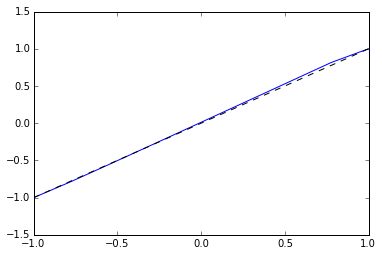

In [17]:
plot(sim['b_f'], sim['db_f'])
plot(sim['b_f'], sim['b_f'], linestyle='--', color='black')

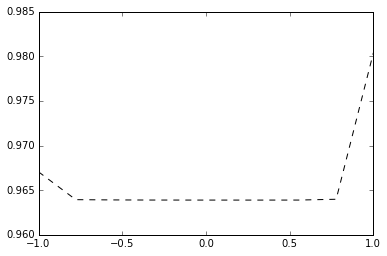

In [18]:
plot(sim['b_f'], sim['p_f'], linestyle='--', color='black')

In [19]:
model


Model object:
------------

- name: "Partial Integration"
- type: "dtmscc"
- file: "models/integration_t_B.yaml

- residuals:

    transition
        1   : 0.0000 : k_1 =        ( (1-delta) + Phi_1(-1) )*k_1(-1) / exp(E)
        2   : 0.0000 : k_2 =        ( (1-delta) + Phi_2(-1) )*k_2(-1) / exp(E)
        3   : -0.5000 : bl = (db_f(-1)/exp(E)-min_c)/(max_c-min_c) - 1

    arbitrage
        1   : 0.0000 : rho_1 - rho_2*S_1/S_2  |   -k_1**theta_f*fac <= db_f <= k_2**theta_f*fac
        2   : 0.0000 : -p_f + (db_f-min_c)/(max_c-min_c)*rho_1 + ((max_c-db_f)/(max_c-min_c))*rho_2*S_2/S_1
        3   : 0.0000 : rho_1 * r_I_1 - 1                     |   0.00 <= i_1 <= inf
        4   : 0.0000 : rho_2 * r_I_2 - 1                     |   0.00 <= i_2 <= inf
        5   : 0.0000 : 1 = (  w_1(1)/ew_1*exp(E(1)) )**(1-gamma)
        6   : 0.0000 : 1 = (  w_2(1)/ew_2*exp(E(1)) )**(1-gamma)
        7   : 0.0000 : beta - (w_1/ew_1)**(1-psi) + (1-beta)*(c_1/ew_1)**(1-psi)
        8   : 0.0000 : beta - 

In [20]:

import pickle

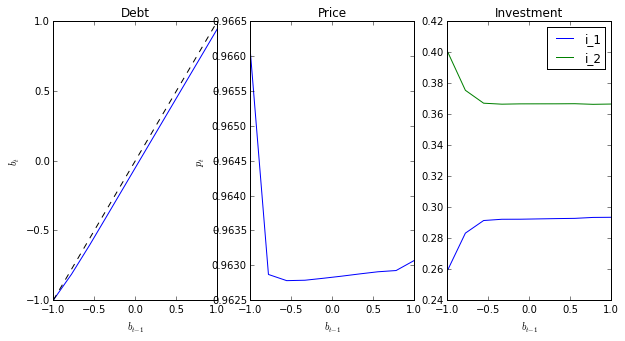

In [118]:
i0 = 1
sim = plot_decision_rule(model, dr, 'bl', i0=i0)

figure(figsize=(10,5))
subplot(131)
plot(sim['b_f'], sim['db_f'])
plot(sim['b_f'], sim['b_f'], color='black', linestyle='--')
xlabel('$b_{t-1}$')
ylabel('$b_{t}$')
title("Debt")
subplot(132)
plot(sim['b_f'], sim['p_f'])
title("Price")
xlabel('$b_{t-1}$')
ylabel('$p_t$')

subplot(133)
plot(sim['b_f'], sim['i_1'], label='i_1')
plot(sim['b_f'], sim['i_2'], label='i_2')
title("Investment")
xlabel('$b_{t-1}$')
legend()





In [77]:
model.calibration['states']

array([ 3.6301792,  3.6301792,  0.       ])

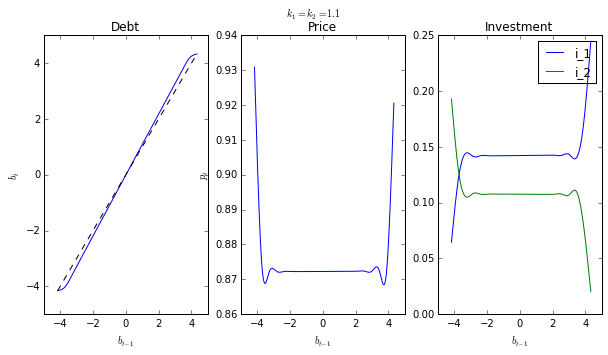

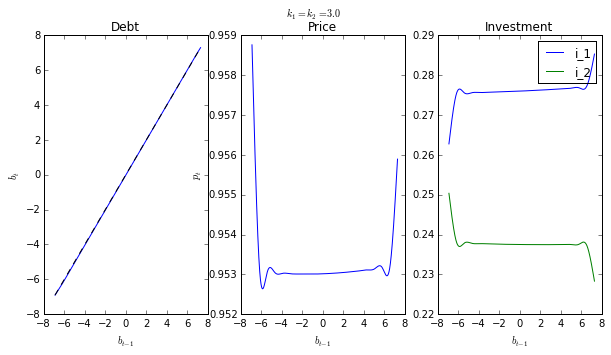

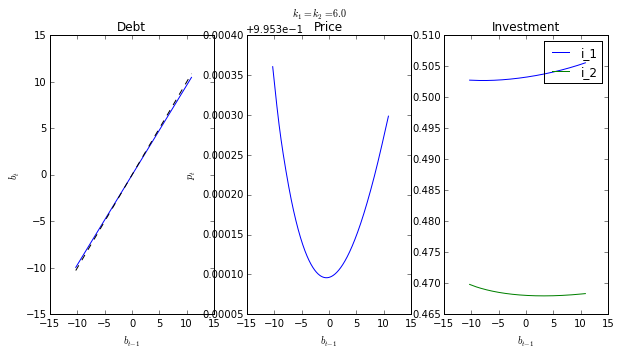

In [53]:
i0 = 2
for k in [1.1, 3.0, 6.0]:
    s0 = [k, k*1.1, 0]
    # s0 = [5.0, 5.0, 0]
    sim = plot_decision_rule(model, dr, 'bl', i0=i0, s0=s0,  n_steps=1000)

    figure(figsize=(10,5))
    subplot(131)
    plot(sim['b_f'], sim['db_f'])
    plot(sim['b_f'], sim['b_f'], color='black', linestyle='--')
    xlabel('$b_{t-1}$')
    ylabel('$b_{t}$')
    title("Debt")
    subplot(132)
    plot(sim['b_f'], sim['p_f'])
    title("Price")
    xlabel('$b_{t-1}$')
    ylabel('$p_t$')

    subplot(133)
    plot(sim['b_f'], sim['i_1'], label='i_1')
    plot(sim['b_f'], sim['i_2'], label='i_2')
    title("Investment")
    xlabel('$b_{t-1}$')
    legend()
    
    suptitle("$k_1=k_2={}$".format(k))


In [64]:
k0 = model.calibration['states']

In [65]:
tsim = simulate(model, dr, 1, n_exp=0)

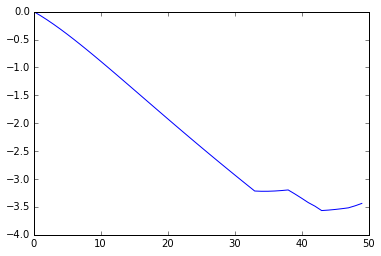

In [66]:
plot(tsim['b_f'])

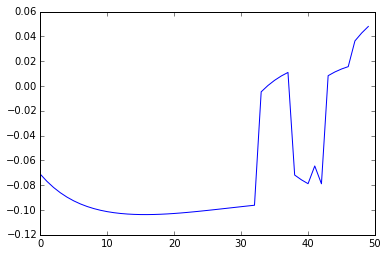

In [67]:
plot(tsim['db_f'] - tsim['b_f'])

In [69]:
tsim = simulate(model, dr, 0, n_exp=1000)

KeyboardInterrupt: 